# Learning with a Wasserstein Loss

#### Master Stat ML

François-Pierre Paty & Raphaël Huille



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris

%matplotlib inline

I will implement algorithm presented in : https://arxiv.org/pdf/1506.05439.pdf

# Implementation

In [157]:
class predictor:
    
    def __init__(self, loss ='wasserstein', method = 'gradient', n_iter = 10,
                 batch_size = 10, eta = 0.01, ground_metric = None, lambda_ = 50):
        
        self.loss = loss
        self.method = method
        self.eta = eta
        self.s = batch_size
        self.n_iter = n_iter
        self.l = lambda_
        self.M = ground_metric # have a default value
        #
        
        # data
        self.X = None
        self.y = None
        self.t = None
        
        # size
        self.m = None
        self.n = None
        self.p = None
        
        # storage
        self.t_list = None
        self.grad_list = None

    def __str__(self):
        sb = []
        
        for key in self.__dict__:
            if key in ['X', 'y', 't', 'M', 't_list', 'grad_list']:
                continue
            sb.append("{key}='{value}'".format(key=key, value=self.__dict__[key]))
                               
        return 'predictor (' + ', '.join(sb) + ')'
    
    def __repr__(self):
        return self.__str__()
    
    def train(self, X, y, theta_0 = None):
        """ main interface methode """
        
        # data
        self.X = X
        self.y = y
        self.t = theta_0 # have a default value
        
        # size
        self.m = y.shape[1]
        self.n = X.shape[0]
        self.p = X.shape[1]
        
        # storage
        self.t_list = np.array([])
        self.grad_list = np.array([])
        
        # default parameters
        if self.M is None :
            self.M = np.full((self.m, self.m), 1) - np.eye(self.m)
        if self.t ==None:
            self.t = np.full((self.p, self.m), 0)
        self.t_list = [ self.t ]
        self.grad_list = []
        
        # train loss :
        if self.loss == 'wasserstein':
            self.train_wasserstein()
            
        if self.loss == 'logistic':
            self.train_logistic()
        
        return self
    
    def Sinkorn_computation(self, y_pred, y):
        """ tool """
        
        m = self.m
        l = self.l
        M = self.M
        
        K = np.exp( -l*M - 1)
        u = np.full(m, 1)
        for i in range(100):
            u = y/np.dot(u, K.T)
            u = y_pred/np.dot(u, K)

        return np.log(u)/l - np.log(u.sum())/(l*m)*np.full(m ,1)
    
    def H_gradient_computation(self, y_pred, x_i):
        """ tool """
        
        m = self.m
        p = self.p
        
        a = np.repeat(np.reshape(y_pred, newshape=(m,1)), repeats=m, axis=1)
        a = a*(np.eye(m,m) - a.T)
        a = np.reshape(a, newshape=(m,1,m))
        x_i = np.reshape(x_i, newshape=(p,1))
        a = np.dot(x_i,a)

        return a
    
    def batch_list_creator(self, s):
        """ tool """
        s = self.s
        n = self.n
        
        index = np.arange(n)
        np.random.shuffle(index)
        i_ = 0
        batch_list =[]
        for i in np.arange(s,n+s,s):
            batch_list+=[index[i_:i]]
            i_ = i
        return batch_list
    
    
    def train_wasserstein(self) :
        """ main algo of the notebook """
        m = self.m
        n = self.n
        p = self.p
        s = self.s
        eta = self.eta
        
        for xx in range(self.n_iter) :
            if self.method == 'sgd' : 
                batch_list = self.batch_list_creator(s) #calling tool
            elif self.method == 'gradient' : 
                batch_list = [np.arange(n)]
            else:
                print('self.method is not valid')
                break
                
            for batch in batch_list :
                # - compute gradient in bacth - #
                gradient = 0
                for i in batch :
                    x_i = self.X[i,:]
                    y_i = self.y[i]
                    y_pred = softmax(np.dot(x_i, self.t))

                    wasserstein_subgrad = self.Sinkorn_computation(y_pred, y_i) #calling tool
                    h_gradient = self.H_gradient_computation(y_pred, x_i) #calling tool
                    
                    gradient += np.dot(h_gradient, wasserstein_subgrad)
                # - end gradient in bacth - #
                
                # new step
                self.t = self.t - eta*gradient
                
                # storage : 
                self.t_list += [self.t]
                self.grad_list += [gradient]
        
        self.t_list = np.array(self.t_list)
        self.grad_list = np.array(self.grad_list)
        return self.t
    
    def train_logistic(self) :
        m = self.m
        n = self.n
        p = self.p
        s = self.s
        eta = self.eta
        y_ = self.y.argmax(axis = 1)
        
        if self.method == 'gradient':
            for xx in range(self.n_iter):
                d = softmax_(np.dot(self.X, self.t)) - np.array([y_==i for i in range(m)]).T
                gradient = np.dot(self.X.T, d)
                self.t = self.t - eta*gradient

                # storage : 
                self.t_list += [self.t]
                self.grad_list += [gradient]
         
        elif self.method == 'sgd':
            for xx in range(self.n_iter):
                batch_list = self.batch_list_creator(s)
                for batch in batch_list:
                    d = softmax_(np.dot(X[batch, :],self.t)) - np.array([y_[batch]==i for i in range(m)]).T
                    gradient = np.dot(X.T[:,batch], d)
                    self.t = self.t - eta*gradient
                # storage : 
                self.t_list += [self.t]
                self.grad_list += [gradient]
        
        self.t_list = np.array(self.t_list)
        self.grad_list = np.array(self.grad_list)
        return self.t
    
    def predict(self, X):
        """ main interface methode """
        
        return softmax_(np.dot(X, self.t))

# Simulation study

In [158]:
def softmax(z):
    e = np.exp(z)
    return e/e.sum() 

def softmax_(z):
    return np.apply_along_axis(softmax, 1, z)

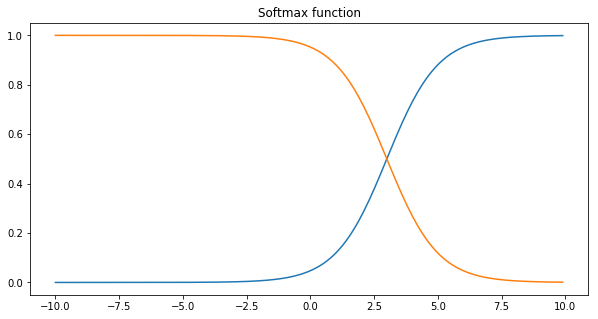

In [159]:
x = np.array([[i,3] for i in np.arange(-10,10,0.1)])
r  = np.array([softmax(k) for k in x])

plt.figure(figsize=(10,5))
plt.title('Softmax function')
plt.plot(x[:,0], r[:, 0], x[:,0], r[:, 1])
plt.show()  

### dataset

In [189]:
# parameters
n = 100 # number of observations
m = 3 # number of class
p = 5 # dimension of parameters

In [176]:
# dataset
X = np.random.uniform(-1,1,size=(n,p))
t = np.floor(np.random.uniform(-1,1,size=(p,m))*10)+1

y_latent = softmax_(np.dot(X,t)) # the 'distribution' over class
y = y_latent.argmax(axis =1) # the class

In [177]:
y

array([9, 9, 1, 0, 3, 2, 0, 2, 9, 5, 9, 4, 5, 3, 1, 8, 6, 3, 4, 6, 3, 7, 4,
       2, 2, 7, 7, 4, 0, 6, 6, 0, 7, 6, 7, 1, 1, 9, 8, 9, 6, 2, 2, 3, 0, 1,
       4, 7, 3, 9, 3, 7, 8, 7, 4, 2, 3, 3, 8, 5, 3, 5, 6, 0, 6, 2, 6, 7, 1,
       2, 7, 7, 1, 2, 0, 2, 3, 2, 5, 9, 2, 7, 5, 5, 3, 3, 8, 9, 5, 4, 1, 4,
       6, 1, 3, 8, 0, 2, 7, 8, 9, 1, 0, 7, 7, 4, 5, 7, 0, 5, 3, 4, 1, 9, 6,
       2, 5, 1, 1, 7, 2, 6, 5, 9, 0, 8, 8, 0, 7, 7, 2, 8, 6, 8, 5, 6, 1, 0,
       6, 3, 1, 4, 4, 3, 1, 4, 6, 7, 9, 9, 1, 1, 0, 8, 9, 9, 7, 6, 0, 0, 2,
       6, 6, 2, 8, 8, 4, 0, 0, 8, 8, 2, 1, 2, 1, 3, 6, 7, 6, 9, 7, 4, 4, 1,
       5, 0, 7, 1, 5, 2, 2, 8, 6, 5, 0, 4, 7, 0, 1, 7, 9, 4, 6, 9, 9, 2, 1,
       5, 9, 8, 9, 0, 3, 4, 1, 5, 8, 5, 7, 7, 4, 6, 1, 7, 8, 8, 4, 5, 1, 5,
       7, 6, 2, 1, 0, 8, 7, 6, 6, 4, 9, 5, 1, 4, 2, 8, 8, 7, 4, 5, 7, 3, 4,
       8, 9, 6, 4, 8, 8, 6, 1, 8, 6, 0, 2, 8, 6, 3, 3, 4, 1, 1, 3, 6, 1, 0,
       6, 6, 3, 3, 6, 0, 4, 7, 2, 8, 7, 8, 3, 0, 8, 2, 0, 8, 0, 1, 6, 8, 2,
       8, 1,

### Analysis of convergence

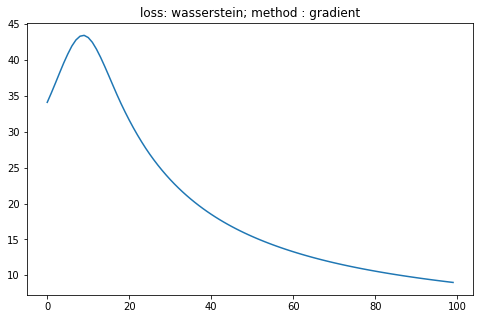

In [183]:
clf = predictor(method='gradient', lambda_=10, n_iter=10)
clf.train(X,y_latent)

norm_list = [np.linalg.norm(g) for g in clf.grad_list]

plt.figure(figsize=(8,5))
plt.title( 'loss: ' + clf.loss  + '; method : '+ clf.method)
plt.plot(norm_list)
plt.show()

In [184]:
np.apply_along_axis(lambda t: np.apply_along_axis(lambda x:x - t[:,2],0, t), 0, clf.t_list)

IndexError: too many indices for array

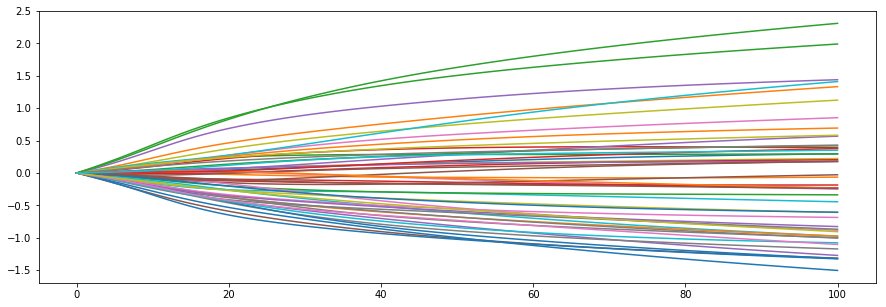

In [185]:
plt.figure(figsize=(15,5))
plt.plot(clf.t_list[:,:,0])
plt.show()

In [186]:
t

array([[  3.,   0.,  -7.,   3.,   9.,   5.,  -7.,   0.,  -7.,   7.],
       [ 10.,  -8.,   9.,   9.,  -4.,  -6.,  -8.,  -3.,  -5.,  -5.],
       [  6.,   2.,   8.,   6.,  -7.,   4.,   8.,  10.,  -9.,   9.],
       [  4.,   4.,   5.,  -6.,   3.,   3.,   5.,  10.,  -5.,   9.],
       [ -7.,   8.,   7.,  -3.,   7.,  -1.,  -3.,  -6.,   0.,   7.],
       [ -7.,   7.,   1.,   5.,  -6.,   8.,   1.,  -8.,   2.,  -3.],
       [ -2.,   7.,  -1.,   2.,  -2.,   6.,   8.,  -2.,  -7.,  -9.],
       [ -8.,   0.,  -9.,  -7.,   4.,  -7.,  -8.,  -3.,   6.,   8.],
       [  1.,   4.,  -4.,  -7.,   8.,  -6.,  -9.,  -8.,   5.,   5.],
       [ -6.,  -9.,  -5.,  -5.,   0.,   9.,  -2.,   6.,   3.,   1.],
       [ -8.,   3.,   4.,   1.,   4.,   9.,  -2.,   4.,   7.,   4.],
       [  4.,   3.,   9.,   2.,   9.,   0.,  -5.,   7.,  -5.,  -1.],
       [  0.,  -8.,   7.,   4.,   7.,  -4.,   3.,   4.,   1.,   8.],
       [ -2.,  -7.,   6.,   0.,   2.,  -3.,  10.,  -7.,  -3.,   4.],
       [  5.,  -9.,   0.,   5.,   

In [187]:
np.apply_along_axis(lambda x:x - t[:,2],0, t)

array([[ 10.,   7.,   0.,  10.,  16.,  12.,   0.,   7.,   0.,  14.],
       [  1., -17.,   0.,   0., -13., -15., -17., -12., -14., -14.],
       [ -2.,  -6.,   0.,  -2., -15.,  -4.,   0.,   2., -17.,   1.],
       [ -1.,  -1.,   0., -11.,  -2.,  -2.,   0.,   5., -10.,   4.],
       [-14.,   1.,   0., -10.,   0.,  -8., -10., -13.,  -7.,   0.],
       [ -8.,   6.,   0.,   4.,  -7.,   7.,   0.,  -9.,   1.,  -4.],
       [ -1.,   8.,   0.,   3.,  -1.,   7.,   9.,  -1.,  -6.,  -8.],
       [  1.,   9.,   0.,   2.,  13.,   2.,   1.,   6.,  15.,  17.],
       [  5.,   8.,   0.,  -3.,  12.,  -2.,  -5.,  -4.,   9.,   9.],
       [ -1.,  -4.,   0.,   0.,   5.,  14.,   3.,  11.,   8.,   6.],
       [-12.,  -1.,   0.,  -3.,   0.,   5.,  -6.,   0.,   3.,   0.],
       [ -5.,  -6.,   0.,  -7.,   0.,  -9., -14.,  -2., -14., -10.],
       [ -7., -15.,   0.,  -3.,   0., -11.,  -4.,  -3.,  -6.,   1.],
       [ -8., -13.,   0.,  -6.,  -4.,  -9.,   4., -13.,  -9.,  -2.],
       [  5.,  -9.,   0.,   5.,   

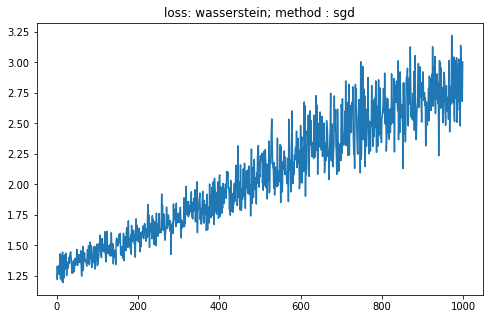

In [181]:
clf = predictor(method='sgd')
clf.train(X,y_latent)

norm_list = [np.linalg.norm(g) for g in clf.grad_list]

plt.figure(figsize=(8,5))
plt.title( 'loss: ' + clf.loss  + '; method : '+ clf.method)
plt.plot(norm_list)
plt.show()

### Analysis of prediction

In [188]:
y_latent_pred = clf.predict(X)
y_pred = y_latent_pred.argmax(axis = 1)
confusion_matrix(y_pred, y)

array([[ 94,   2,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0, 109,   0,   0,   0,   2,   0,   1,   2,   2],
       [  1,   0,  94,   0,   0,   0,   0,   2,   2,   0],
       [  1,   2,   2,  87,   0,   2,   2,   0,   1,   0],
       [  0,   0,   0,   1,  94,   1,   1,   1,   0,   0],
       [  1,   2,   0,   0,   0,  80,   2,   0,   1,   0],
       [  0,   0,   0,   1,   0,   0, 108,   1,   1,   0],
       [  0,   0,   2,   0,   1,   2,   0, 103,   1,   0],
       [  0,   2,   0,   1,   0,   0,   1,   0, 102,   0],
       [  0,   1,   1,   0,   1,   0,   1,   0,   0,  77]])

# On iris dataset

### dataset

In [130]:
def create_latent(y, part_ = 0):
    m = np.unique(y).shape[0]
    y_latent = np.array([ [part_/m]*m for i in y])
    for v,i in enumerate(y) :
        y_latent[v,i]+= 1 - part_
    return y_latent

In [131]:
X = load_iris().data
y = load_iris().target
y_latent = create_latent(y)

In [132]:
y_latent

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.

### Analysis of convergence

In [145]:
M = np.array([[0,1,1],[1,0,-1],[1,-1,0]])
M

array([[ 0,  1,  1],
       [ 1,  0, -1],
       [ 1, -1,  0]])

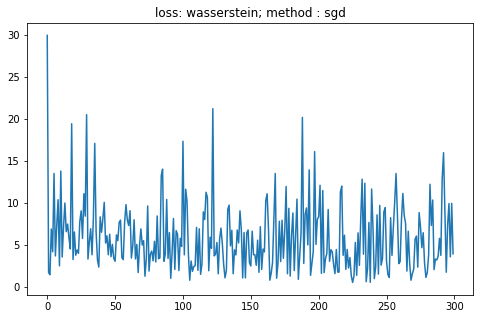

In [146]:
clf = predictor(method='sgd',batch_size=10 ,eta = 0.01,n_iter=20, lambda_=10, ground_metric=M)
clf.train(X,y_latent)

norm_list = [np.linalg.norm(g) for g in clf.grad_list]

plt.figure(figsize=(8,5))
plt.title( 'loss: ' + clf.loss  + '; method : '+ clf.method)
plt.plot(norm_list)
plt.show()

### Analysis of prediction

In [147]:
y_latent_pred = clf.predict(X)
y_pred = y_latent_pred.argmax(axis = 1)
confusion_matrix(y_pred, y)

array([[50,  0,  0],
       [ 0,  3, 47],
       [ 0, 47,  3]])

### Iris with Logistic

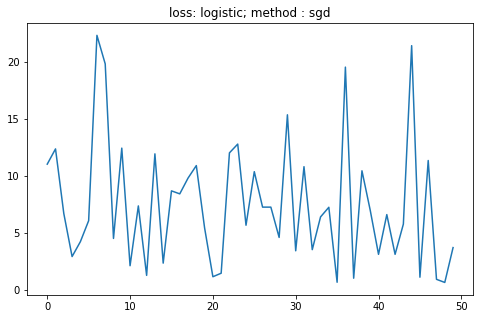

In [111]:
clf = predictor(loss = 'logistic', method='sgd', batch_size=5, eta = 0.01, n_iter=50)
clf.train(X,y_latent)

norm_list = [np.linalg.norm(g) for g in clf.grad_list]

plt.figure(figsize=(8,5))
plt.title( 'loss: ' + clf.loss  + '; method : '+ clf.method)
plt.plot(norm_list)
plt.show()

In [112]:
y_latent_pred = clf.predict(X)
y_pred = y_latent_pred.argmax(axis = 1)
confusion_matrix(y_pred, y)

array([[50,  0,  0],
       [ 0, 44,  0],
       [ 0,  6, 50]])